In [125]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
%matplotlib widget
import matplotlib.pyplot as plt
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
from utils.preprocess import load_ninapro_data, preprocess_emg
dataPath = parentDir / "data" / "raw" / "ninapro-db2"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
subject_number = 1
exercise_number = 1
channel_to_plot = 2

In [118]:
emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)

In [119]:
filtered_emg = preprocess_emg(emg[:, channel_to_plot], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)

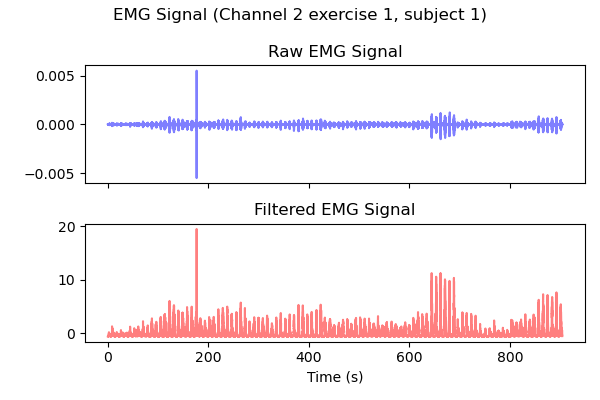

In [120]:
 # Plot raw and filtered EMG signals for comparison

fig, axs = plt.subplots(2,1, figsize=(6, 4), sharex=True)
axs[0].plot(time, emg[:, channel_to_plot], color='blue', label='Raw EMG', alpha=0.5)
axs[1].plot(time, filtered_emg, color='red', label='Filtered EMG', alpha=0.5)
plt.suptitle(f'EMG Signal (Channel {channel_to_plot} exercise {exercise_number}, subject {subject_number})')
plt.xlabel('Time (s)')
axs[0].set_title('Raw EMG Signal')
axs[1].set_title('Filtered EMG Signal')
# plt.ylabel('Amplitude')
# plt.legend()
plt.tight_layout()
plt.show()

In [168]:
def create_epochs(emg_signal, stimulus, repetition, Fs, pre_stim=0, post_stim=1):
    """ Create epochs for each gesture and repetition based on stimulus and repetition markers."""
    unique_channels = emg_signal.shape[1] if len(emg_signal.shape) > 1 else 1
    unique_gestures = np.unique(stimulus)
    unique_repetitions = range(1,7)  # 6 repetitions

    # empty numpy array of size (number of gestures x number of repetitions)
    epochs = np.zeros((len(unique_gestures)*len(unique_repetitions), (post_stim-pre_stim)*Fs, unique_channels), dtype=object)
    print(epochs.shape)
    epoch_gesture_labels = np.zeros((len(unique_gestures)*len(unique_repetitions)), dtype=int)
    epoch_repetition_labels = np.zeros((len(unique_gestures)*len(unique_repetitions)), dtype=int)

    count = 0
    for gesture in unique_gestures:
        if gesture == 0:
            continue  # Skip rest
        for rep in unique_repetitions:
            indices = np.where((stimulus == gesture) & (repetition == rep))[0]
            if len(indices) == 0:
                continue
            start_idx = indices[0] - int(pre_stim * Fs)
            end_idx = indices[-1] + int(post_stim * Fs)
            if start_idx < 0 or end_idx > len(emg_signal):
                continue  # Skip if out of bounds
            epoch = emg_signal[start_idx:end_idx]
            print(np.shape(epoch))
            epochs[count, :, :] = epoch
            epoch_gesture_labels[count] = gesture
            epoch_repetition_labels[count] = rep
            count += 1
    return epochs, epoch_gesture_labels, epoch_repetition_labels

In [169]:
epochs, epoch_gesture_labels, epoch_repetition_labels = create_epochs(filtered_emg, stimulus, repetition, Fs)

(108, 2000, 1)
(10479,)


ValueError: could not broadcast input array from shape (10479,) into shape (2000,1)

In [159]:
epochs[0]

array([array([-0.45683313, -0.45639325, -0.45640732, ...,  0.24315752,
               0.24831822,  0.25331643], shape=(10479,))              ],
      dtype=object)

In [160]:
np.shape(epochs)

(108, 1)

In [ ]:

gesture_durations_df = pd.DataFrame(columns=["Subject", "Gesture", "Repetition", "Duration"])
gesture_durations = []
emg_clean = np.zeros_like(emg)

windowTimeS = 1  # in seconds

# Go through all subjects and save duration of each gesture and each repetition
for subject_number in range(1,21):
    print(f"Processing subject {subject_number}...")
    emg, stimulus, repetition, time, Fs = load_ninapro_data(subject_number=subject_number, exercise_number=exercise_number, dataPath=dataPath)
    for ch in range(emg.shape[1]):
        emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue
        for rep in range(1, 7):
            indices = np.where((stimulus == gesture) & (repetition == rep))[0]
            if len(indices) == 0:
                continue
            duration = time[indices[-1]] - time[indices[0]]
            gesture_durations.append({"Subject": subject_number, "Gesture": gesture, "Repetition": rep, "Duration": duration})
            # Epoch data for each gesture and repetition for ML purposes
            

gesture_durations_df = pd.DataFrame(gesture_durations)
gesture_durations_df.to_csv(parentDir / "data" / "processed" / "gesture_durations.csv", index=False)


Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20


In [137]:
durations_df.groupby("Gesture")["Duration"].median()
# durations_df.groupby("Gesture")["Duration"].min()

Gesture
1     6.43825
2     6.42675
3     4.16275
4     3.96825
5     3.23175
6     3.10375
7     6.45350
8     4.65250
9     5.04750
10    5.00725
11    5.28750
12    3.83800
13    3.30800
14    3.03775
15    3.50225
16    3.90900
17    3.33150
Name: Duration, dtype: float64

In [ ]:


emg_clean = np.zeros_like(emg)
for ch in range(emg.shape[1]):
    emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue
        for rep in range(1, 7):
            mask = (stimulus == gesture) & (repetition == rep)
            if np.sum(mask) == 0:
                continue
            start_idx = np.where(mask)[0][0]
            end_idx = np.where(mask)[0][-1]



In [122]:
# Preprocess all channels
# Epoch the data based on stimulus and repetition information
emg_clean = np.zeros_like(emg)
for ch in range(emg.shape[1]):
    emg_clean[:, ch] = preprocess_emg(emg[:, ch], Fs, smoothen=True, lowcut=20.0, highcut=450.0, smooth_window=0.05, normalize=True)
    # Epoching code would go here
    for gesture in np.unique(stimulus):
        if gesture == 0:
            continue  # Skip rest gesture
        gesture_indices = np.where(stimulus == gesture)[0]
        for repetition in range(1,7):  #6 repetitions
            repetition_indices = np.where(repetition == repetition)[0]
            epoch_indices = np.intersect1d(gesture_indices, repetition_indices)
            if len(epoch_indices) > 0:
                emg_epoch = emg_clean[epoch_indices, ch]
                # Store or process the epoch as needed
                # For example, you could append it to a list or save it to a file
                # epochs.append(emg_epoch)
                # Or you could compute features from the epoch
                # features = extract_features(emg_epoch, Fs)
                # Store features in a dictionary
                # feature_dict[(gesture, repetition)] = features


ValueError: Calling nonzero on 0d arrays is not allowed. Use np.atleast_1d(scalar).nonzero() instead. If the context of this error is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.

In [ ]:
fs = 2000
win_s, step_s = 200, 100
win = int(fs * win_s / 1000)
step = int(fs * step_s / 1000)

X, y, reps = [], [], []

for g in np.unique(stimulus):
    for r in np.unique(repetition[stimulus == g]):
        idx = np.where((stimulus == g) & (repetition == r))[0]
        for i in range(0, len(idx)-win, step):
            seg = emg_clean[idx[i:i+win], :]
            if seg.shape[0] == win:
                X.append(seg)
                y.append(g)
                reps.append(r)

X, y, reps = np.array(X), np.array(y), np.array(reps)
print("X:", X.shape, "y:", y.shape, "reps:", np.unique(reps))


X: (8881, 400, 12) y: (8881,) reps: [0 1 2 3 4 5 6]
